# Panagiotis Karamitopoulos
# Assignment 3 - Συνδυασμός Μοντέλων

# Import Libraries

In [177]:
import yfinance as yf
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt





#Load Data

In [178]:

ticker_symbol = "DX-Y.NYB"
ticker = yf.Ticker(ticker_symbol)
df = ticker.history(period="5y").reset_index(drop=False)
df


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-11-03 00:00:00-05:00,94.050003,94.050003,93.290001,93.550003,0,0.0,0.0
1,2020-11-04 00:00:00-05:00,93.089996,94.300003,93.089996,93.410004,0,0.0,0.0
2,2020-11-05 00:00:00-05:00,93.339996,93.550003,92.489998,92.529999,0,0.0,0.0
3,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003,0,0.0,0.0
4,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003,0,0.0,0.0
...,...,...,...,...,...,...,...,...
1253,2025-10-28 00:00:00-04:00,98.750000,98.949997,98.570000,98.690002,0,0.0,0.0
1254,2025-10-29 00:00:00-04:00,98.739998,99.360001,98.620003,99.220001,0,0.0,0.0
1255,2025-10-30 00:00:00-04:00,99.139999,99.720001,98.919998,99.529999,0,0.0,0.0
1256,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003,0,0.0,0.0


#Drop Volume, Dividends and Stock Splits

In [54]:
df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)
df


,Date,Open,High,Low,Close
0,2020-11-03 00:00:00-05:00,94.050003,94.050003,93.290001,93.550003
1,2020-11-04 00:00:00-05:00,93.089996,94.300003,93.089996,93.410004
2,2020-11-05 00:00:00-05:00,93.339996,93.550003,92.489998,92.529999
3,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003
4,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003
...,...,...,...,...,...
1253,2025-10-28 00:00:00-04:00,98.750000,98.949997,98.570000,98.690002
1254,2025-10-29 00:00:00-04:00,98.739998,99.360001,98.620003,99.220001
1255,2025-10-30 00:00:00-04:00,99.139999,99.720001,98.919998,99.529999
1256,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003


#Question 1

#Plot Variables

In [179]:
fig = px.line(df, x='Date', y=['Open', 'High', 'Low', 'Close'])
fig.update_layout(title="US Dollar Price over the Last 5 Years", xaxis_title="Date", yaxis_title="Price", hovermode="x unified", height=600, template="presentation")
fig.show()

#Question 2

Από το παραπάνω διάγραμμα προκύπτει ότι οι χρονοσειρές των open, close, high και low είναι μη στατικές. Σύμφωνα με τη θεωρία του μαθήματος στα στατικά δεδομένα δεν αναφέρεται ο χρόνος καταγραφής, ενώ τα δυναμικά δεδομένα αλλάζουν συνεχώς μετά την καταγραφή τους και για αυτό ενημερώνονται διαρκώς.
Επιπλέον, από το διάγραμμα παρατηρείται ότι οι μέση τιμή και η διακύμανση των μεταβλητών μεταβάλλονται με τον χρόνο γεγονός που επαληθεύει τον προαναφερθέντα ισχυρισμό.




#Question 3

Η εκπαίδευση ενός Regressor σε μη στατικές χρονοσειρές μπορεί να οδηγήσει σε λανθασμένα αποτελέσματα καθώς:
1. Ο Regressor θα υποθέσει ότι η σχέση μεταξύ χαρακτηριστικών και στόχου είναι σταθερή. Για παράδειγμα, αν το μοντέλο εκπαιδευτεί πάνω σε δεδομέντα που έχουν αυξητική τάση (πχ 2021-2022),τότε οι προβλέψεις του θα είναι αυξητικές, παρόλο που η αγορά μπορεί να έχει αρχίσει να πέφτει.
2. Σε μη στατικές χρονοσειρές οι τιμές μπορούν να αλλάξουν από μακροοικονομικά γεγονότα (πχ πολιτικά, υγειονομικά, τεχνολογικά κλπ). Συνεπώς, το μοντέλο μπορεί να υπερπροσαρμοστεί (overfitting) στα δεδομένα εκπαίδευσης και να αποτυγχάνει σε νέες προβλέψεις.



#Question 4

#US Dollar Trend – June-July 2025

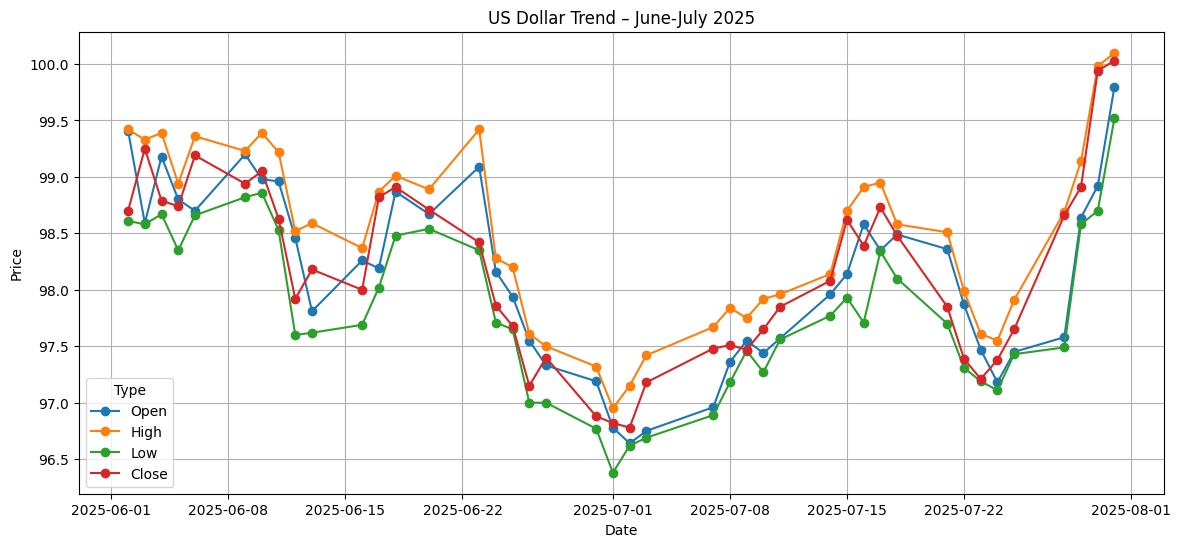

In [89]:
mask_june_july_2025 = df[(df['Date'] >= '2025-06-01') & (df['Date'] <= '2025-07-31')]
plt.figure(figsize=(14, 6))
plt.plot(mask_june_july_2025['Date'], mask_june_july_2025['Open'], marker='o', label='Open')
plt.plot(mask_june_july_2025['Date'], mask_june_july_2025['High'], marker='o', label='High')
plt.plot(mask_june_july_2025['Date'], mask_june_july_2025['Low'], marker='o', label='Low')
plt.plot(mask_june_july_2025['Date'], mask_june_july_2025['Close'], marker='o', label='Close')
plt.title("US Dollar Trend – June-July 2025")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(title="Type")
plt.grid(True)
plt.show()

Aπό το παραπάνω διάγραμμα παρατηρείται μια πτωτική τάση του δολαρίου τον Ιούνιο του 2025, καθώς η τιμή του μειώθηκε από τα 99.5 περίπου στις αρχές του μήνα, στο 96.7 περίπου στο τέλος του μήνα, ενώ τον Ιούλιου του 2025 παρατηρείται μια ανοδική τάση του δολαρίου από το 96.7 στο 99.7, ξεπερνώντας την τιμή του στις αρχές του Ιουνίου.

Η πτώση του Ιουνίου μπορεί να οφείλεται στους εξής παράγοντες:
1. Στις πολιτικές του Τραμπ με τους δασμούς και στις ανησυχίες που προκαλούνται ως προς την κυριαρχία του δολαρίου.
2. Πέρα από τους δασμούς Τραμπ, ένας άλλος σημαντικός παράγοντος για την πτώση του δολαρίου είναι και οι πιέσεις που ασκεί η Ουάσινγκτον στην ομοσπονδιακή τράπεζα των ΗΠΑ (Federal Reserve).
3. Πιθανόν να εικαζόταν μια μόνιμη αλλαγή στο καθεστώς του δολαρίου ως ασφαλούς καταφυγίου για τους επενδυτές σε περιόδους αβεβαιότητας.

Αντιθέτως, η άνοδος του Ιουλίου μπορεί να οφείλεται στους εξής παράγοντες:
1. Γεωπολιτικοί παράγοντες και αύξηση της τιμής του πετρελαίου. Η αύξηση της τιμής του πετρελαίου ευνοεί το δολάριο, πιέζοντας από την άλλη πλευρά τις εξαρτώμενες ενεργειακά οικονομίες.
2. Υψηλές αποδόσεις των αμερικανικών ομολόγων λόγω αυξήσεων των επιτοκίων από τη Federal Reserve.



#Question 5

Η εκτίμηση της τιμής Close του δολαρίου την επόμενη μέρα με μοναδική πληροφορία τα σημερινά Open, High, Low, και Close θα έχει περιορισμένη προβλεψιμότητα.  Η συνάρτηση της μορφής: $f(o_t, h_t, l_t, c_t) = c_{t+1}$ δεν μπορεί να προβλέψει με ακρίβεια τη μελλοντική τιμή, καθώς πρέπει να ληφθεί υπόψη η δυναμικότητα της αγοράς. Συνεπώς, θα πρέπει να ληφθούν υπόψη εξωτερικοί παράγοντες και παλαιότερα δεδομένα.  


#Question 6

Ο τυχαίος διαχωρισμός των δεδομένων σε train-test δεν έχει νόημα γιατί στις χρονοσειρές τα δεδομένα έχουν χρονική εξάρτηση, καθώς οι μελλοντικές τιμές εξαρτώνται από τις προηγούμενες. Συνεπώς, αν τα δεδομένα διαχωριστούν τυχαία τότε το μοντέλο θα εκπαιδευτεί σε μελλοντικές τιμές και θα οδηγεί σε λανθασμένες προβλέψεις προηγούμενων τιμών. Το ορθό είναι το μοντέλο να εκπαιδευτεί σε παλιά δεδομένα και να αξιολογηθεί σε νεώτερα δεδομένα.


#Question 7

#Split Dataset to Train-Test and Drop Date


In [90]:
train_set = df[df['Date'] < '2024-01-01']
test_set = df[(df['Date'] >= '2024-01-01') & (df['Date'] < '2025-01-01')]
train_set = train_set.drop(columns=['Date'])
test_set = test_set.drop(columns=['Date'])


#Question 8

In [91]:
def create_timeframes(df, N):
    x, y = [], []
    for i in range(len(df) - N):
        x.append(df.iloc[i:i+N][['Open', 'High', 'Low', 'Close']].values)
        y.append(df.iloc[i+N]['Close'])
    return np.array(x), np.array(y)

#Question 9

Για την πρόβλεψη της επόμενη ημέρας το μέγεθος Ν του timeframe θα πρέπει να είναι σχετικά μικρό (π.χ. 5-10), καθώς τα πιο πρόσφατα δεδομένα έχουν μεγαλύτερη επίδραση στην επόμενη ημέρα. Με αυτόν τον τρόπο αποφεύγεται ο θόρυβος και η υπερπροσαρμογή σε λιγότερο σχετικά δεδομένα. Από την άλλη πλευρά για προβλέψεις με μακρινό χρονικό ορίζοντα θα πρέπει να χρησιμοποιηθεί μεγαλύτερο Ν (π.χ. 30-50), ώστε το μοντέλο να δει τις μακροχρόνιες τάσεις της αγοράς και όχι μόνο τις βραχυπρόθεσμες διακυμάνσεις.

#Question 10

#Create x_train, y_train, x_test and y_test





In [92]:

x_train, y_train = create_timeframes(train_set, 5)
x_test, y_test = create_timeframes(test_set, 5)


#Reshape x_train and x_test

In [93]:
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
print("First Input of x_train:", x_train[0])
x_train.shape, y_train.shape



First Input of x_train: [93.08999634 94.30000305 93.08999634 93.41000366 93.33999634 93.55000305
 92.48999786 92.52999878 92.56999969 92.81999969 92.18000031 92.23000336
 92.23999786 92.95999908 92.12999725 92.73000336 92.76000214 92.97000122
 92.59999847 92.75      ]


((788, 20), (788,))

#Question 11

#11.a Linear Regressor

In [94]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train, y_train)
y_pred_train_linear_regression = linear_regression_model.predict(x_train)
y_pred_test_linear_regression = linear_regression_model.predict(x_test)

mae_train_linear_regression = round(mean_absolute_error(y_train, y_pred_train_linear_regression), 3)
mae_test_linear_regression = round(mean_absolute_error(y_test, y_pred_test_linear_regression), 3)

print('Linear Regression')
print(f'Train Set Mean Absolute Error (MAE): {mae_train_linear_regression}')
print(f'Test Set - Mean Absolute Error (MAE): {mae_test_linear_regression}')

Linear Regression
Train Set Mean Absolute Error (MAE): 0.345
Test Set - Mean Absolute Error (MAE): 0.284


#11.b	Random Forest Regressor

In [95]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(x_train, y_train)
y_pred_train_random_forest = random_forest_model.predict(x_train)
y_pred_test_random_forest = random_forest_model.predict(x_test)

mae_train_random_forest = round(mean_absolute_error(y_train, y_pred_train_random_forest), 3)
mae_test_random_forest = round(mean_absolute_error(y_test, y_pred_test_random_forest), 3)

print('Random Forest')
print(f'Train Set Mean Absolute Error (MAE): {mae_train_random_forest}')
print(f'Test Set - Mean Absolute Error (MAE): {mae_test_random_forest}')

Random Forest
Train Set Mean Absolute Error (MAE): 0.147
Test Set - Mean Absolute Error (MAE): 0.323


#11.c	Bagging

In [96]:
bagging_model = BaggingRegressor(estimator=LinearRegression(), n_estimators=40)
bagging_model.fit(x_train, y_train)
y_pred_train_bagging = bagging_model.predict(x_train)
y_pred_test_bagging = bagging_model.predict(x_test)

mae_train_bagging = round(mean_absolute_error(y_train, y_pred_train_bagging), 3)
mae_test_bagging = round(mean_absolute_error(y_test, y_pred_test_bagging), 3)

print('Bagging')
print(f'Train Set Mean Absolute Error (MAE): {mae_train_bagging}')
print(f'Test Set - Mean Absolute Error (MAE): {mae_test_bagging}')

Bagging
Train Set Mean Absolute Error (MAE): 0.345
Test Set - Mean Absolute Error (MAE): 0.286


#11.d	XG-Boost  

In [97]:
xg_boost_model = XGBRegressor()
xg_boost_model.fit(x_train, y_train)
y_pred_train_xg_boost = xg_boost_model.predict(x_train)
y_pred_test_xg_boost = xg_boost_model.predict(x_test)

mae_train_xg_boost = round(mean_absolute_error(y_train, y_pred_train_xg_boost), 3)
mae_test_xg_boost = round(mean_absolute_error(y_test, y_pred_test_xg_boost), 3)

print('XG-Boost')
print(f'Train Set Mean Absolute Error (MAE): {mae_train_xg_boost}')
print(f'Test Set - Mean Absolute Error (MAE): {mae_test_xg_boost}')

XG-Boost
Train Set Mean Absolute Error (MAE): 0.022
Test Set - Mean Absolute Error (MAE): 0.361


#11.e	Stacking

In [98]:
stacking_model = StackingRegressor(estimators=[('lrm', linear_regression_model), ('dt', DecisionTreeRegressor(random_state=42))], final_estimator=LinearRegression())
stacking_model.fit(x_train, y_train)
y_pred_train_stacking = stacking_model.predict(x_train)
y_pred_test_stacking = stacking_model.predict(x_test)

mae_train_stacking = round(mean_absolute_error(y_train, y_pred_train_stacking), 3)
mae_test_stacking = round(mean_absolute_error(y_test, y_pred_test_stacking), 3)

print('Stacking')
print(f'Train Set Mean Absolute Error (MAE): {mae_train_stacking}')
print(f'Test Set - Mean Absolute Error (MAE): {mae_test_stacking}')


Stacking
Train Set Mean Absolute Error (MAE): 0.357
Test Set - Mean Absolute Error (MAE): 0.288


#Plot MAE

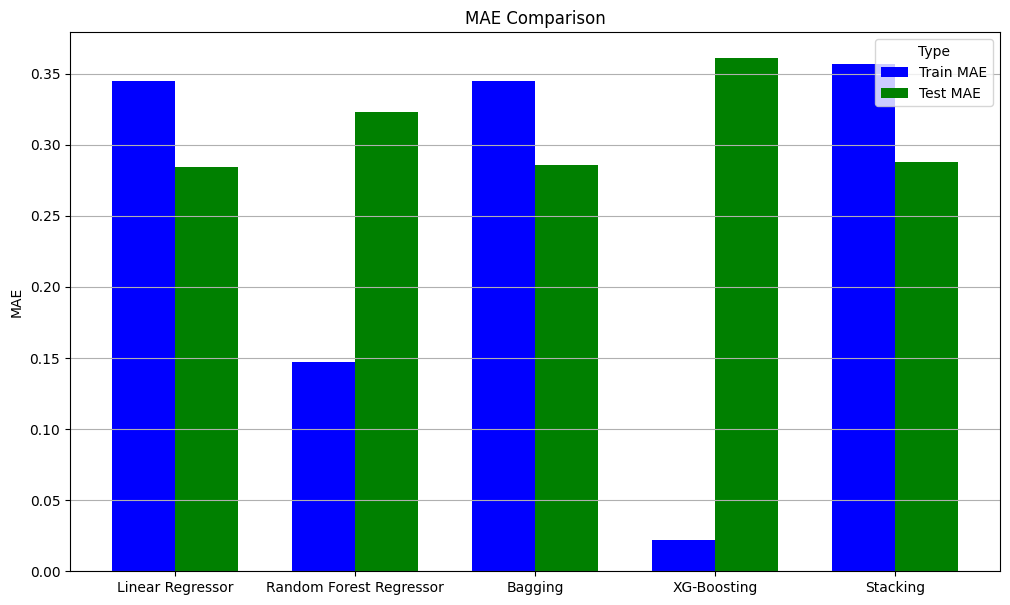

In [99]:
plt.figure(figsize=(12, 7))
x = ['Linear Regressor', 'Random Forest Regressor', 'Bagging', 'XG-Boosting', 'Stacking']
y_train = [mae_train_linear_regression, mae_train_random_forest, mae_train_bagging, mae_train_xg_boost, mae_train_stacking]
y_test = [mae_test_linear_regression, mae_test_random_forest, mae_test_bagging, mae_test_xg_boost, mae_test_stacking]
width = 0.35
plt.bar((np.arange(len(x))-width/2), y_train, width, color='blue', label='Train MAE')
plt.bar((np.arange(len(x))+width/2), y_test, width, color='green', label='Test MAE')
plt.title('MAE Comparison')
plt.xticks(np.arange(len(x)), x)
plt.ylabel('MAE')
plt.grid(axis='y')
plt.legend(title='Type')
plt.show()

1.	Linear Regressor: Γραμμική προσέγγιση για την πρόβλεψη.
2.	Random Forest Regressor: Συνδιάζει τις προβλέψεις από πολλά δέντρα παρεμβολής. Η τελική πρόβλεψη προκύπτει από τον μέσο όρο των προβλέψεων των μοντέλων.
3.	Bagging Regressor: Δημιουργία διαφορετικών δειγμάτων, τα οποία εκπαιδεύονται με Linear Regression και έτσι προκύπτουν διαφορετικά μοντέλα. H τελική πρόβλεψη προκύπτει από τον μέσο όρο των προβλέψεων των διαφορετικών μοντέλων.
4.	XG-Boost Regressor: Δημιουργούνται δέντρα παρεμβολής ακολουθιακά, που το κάθε επόμενο βασίζεται στην απόδοση του προηγούμενου και προσπαθεί να τη βελτιώσει (να μην κάνει τα ίδια λάθη). Η τελική πρόβλεψει προκύπτει από συνδιασμό των αποφάσεων όλων των δέντρων με βάρη.
5.	Stacking Regressor: Συνδυάσμός προβλέψεων διαφορετικών μοντέλων σε ένα μετα-μοντέλο, το οποίο λαμβάνει την τελική βελτιωμένη απόφαση.


#Question 12

#12.a

In [150]:
df['Month'] = df['Date'].dt.month - 1
df['Month'] = df['Month'] / 11

O μήνας ενδεχομένως θα συμβάλει στη βελτίωση των προβλέψεων καθώς προστίθεται η εποχικότητα στη χρονοσειρά. Αν η τιμή του δολαρίου αυξομειώνεται σε
συγκεκριμένα χρονικά διαστήματα με σταθερή περιοδικότητα μεταξύ των εναλλαγών, τότε η προσθήκη του μήνα θα βοηθήσει τα μοντέλα να κάνουν καλύτερες προβλέψεις.


#12.b

In [151]:
for col in ['Open', 'High', 'Low', 'Close']:
    df[f'Log_Returns_{col}'] = np.log(df[col] / df[col].shift(1))


#12.c

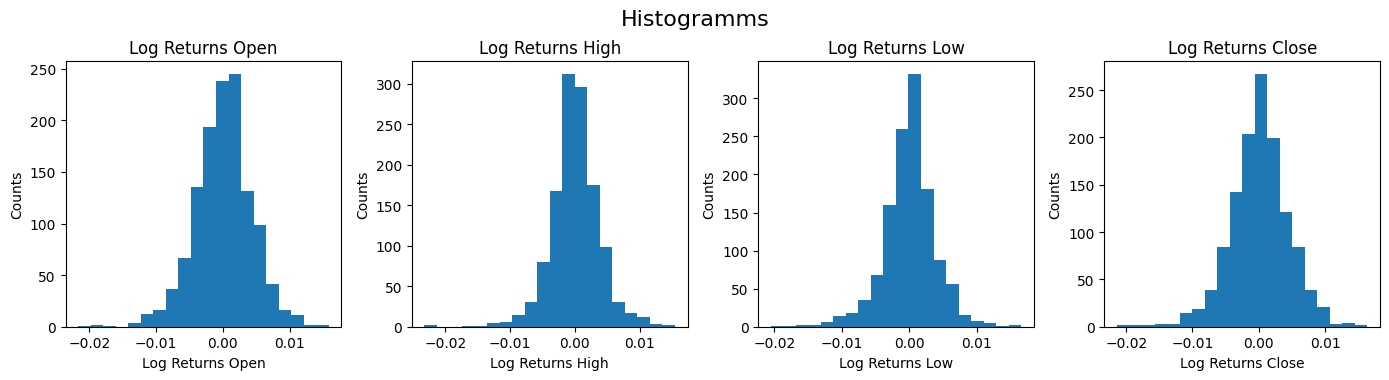

In [152]:
features = ['Log_Returns_Open', 'Log_Returns_High', 'Log_Returns_Low', 'Log_Returns_Close']
title = ['Log Returns Open', 'Log Returns High', 'Log Returns Low', 'Log Returns Close']
plt.figure(figsize=(14, 10))
plt.suptitle('Histogramms', fontsize=16)
for i in range(len(features)):
    plt.subplot(3, 4, i + 1)
    plt.hist(df[features[i]], bins=20)
    plt.title(f'{title[i]}')
    plt.xlabel(title[i])
    plt.ylabel('Counts')
plt.tight_layout()
plt.show()




Οι λογαριθμικές επιστροφές κανονικοποιούν τα δεδομένα γύρω από το 0, μειώνουν την επίδραση των ακραίων τιμών και σταθεροποιούν τις διακυμάνσεις. Συνεπώς, η ακρίβεια των προβλέψεων των μοντέλων βελτιώνεται καθώς πολλά μοντέλα παλινδρόμησης αποδίδουν καλύτερα σε συμμετρικές κατανομές.

#12.d

$r_{t+1}=ln{(c_{t+1}/c_t)} => e^{r_{t+1}}=c_{t+1}/c_t=>c_{t+1}=e^{r_{t+1}}*c_t$

In [153]:
c_t=0.95
r_t1=0.01
c_t1=c_t*np.exp(r_t1)
print("c_(t+1)=",c_t1)


c_(t+1)= 0.9595476587299595


#12.e

#12.e.7 Split Dataset to Train-Test and Drop Date


In [154]:
df.dropna(inplace=True)
train_set = df[df['Date'] < '2024-01-01']
test_set = df[(df['Date'] >= '2024-01-01') & (df['Date'] < '2025-01-01')]


#12.e.8

In [155]:
def create_timeframes_12(df, N):
    x, y, c_t, y_dates = [], [], [], []
    for i in range(len(df) - N):
        x.append(df.iloc[i:i+N][['Log_Returns_Open', 'Log_Returns_High', 'Log_Returns_Low', 'Log_Returns_Close', 'Month']].values)
        y.append(df.iloc[i+N]['Log_Returns_Close'])
        c_t.append(df.iloc[i+N-1]['Close'])
        y_dates.append(df.iloc[i+N]['Date'])
    return np.array(x), np.array(y), np.array(c_t), y_dates



#12.e.10 Create x_train, y_train, x_test and y_test


In [156]:
x_train, y_train, c_t_train, y_dates_train = create_timeframes_12(train_set, 5)
x_test, y_test, c_t_test, y_dates_test = create_timeframes_12(test_set, 5)


#Reshape x_train and x_test

In [157]:
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
print("First Input of x_train:", x_train[0])
x_train.shape, y_train.shape



First Input of x_train: [-8.28358951e-03 -7.83395482e-03 -3.35731687e-03 -3.24740942e-03
  9.09090909e-01 -3.57125898e-03  1.50715273e-03 -5.42597294e-04
  5.40658737e-03  9.09090909e-01  5.62168262e-03  1.07590343e-04
  5.08853187e-03  2.15620474e-04  9.09090909e-01 -6.47095766e-04
  2.57812865e-03  1.08008599e-04  3.12181656e-03  9.09090909e-01
  3.33859757e-03 -7.51271250e-04  1.83395239e-03 -8.60234796e-04
  9.09090909e-01]


((786, 25), (786,))

#10.e.11

#10.e.11.a Linear Regressor

In [158]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train, y_train)
y_pred_train_linear_regression = linear_regression_model.predict(x_train)
y_pred_test_linear_regression = linear_regression_model.predict(x_test)

mae_train_linear_regression = round(mean_absolute_error(y_train, y_pred_train_linear_regression), 6)
mae_test_linear_regression = round(mean_absolute_error(y_test, y_pred_test_linear_regression), 6)

print('Linear Regression')
print(f'Train Set Mean Absolute Error (MAE): {mae_train_linear_regression}')
print(f'Test Set - Mean Absolute Error (MAE): {mae_test_linear_regression}')




Linear Regression
Train Set Mean Absolute Error (MAE): 0.003403
Test Set - Mean Absolute Error (MAE): 0.002841


#12.e.11.b	Random Forest Regressor

In [159]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(x_train, y_train)
y_pred_train_random_forest = random_forest_model.predict(x_train)
y_pred_test_random_forest = random_forest_model.predict(x_test)

mae_train_random_forest = round(mean_absolute_error(y_train, y_pred_train_random_forest), 6)
mae_test_random_forest = round(mean_absolute_error(y_test, y_pred_test_random_forest), 6)

print('Random Forest')
print(f'Train Set Mean Absolute Error (MAE): {mae_train_random_forest}')
print(f'Test Set - Mean Absolute Error (MAE): {mae_test_random_forest}')

Random Forest
Train Set Mean Absolute Error (MAE): 0.001311
Test Set - Mean Absolute Error (MAE): 0.002846


#12.e.11.c	Bagging


In [160]:
bagging_model = BaggingRegressor(estimator=LinearRegression(), n_estimators=40)
bagging_model.fit(x_train, y_train)
y_pred_train_bagging = bagging_model.predict(x_train)
y_pred_test_bagging = bagging_model.predict(x_test)

mae_train_bagging = round(mean_absolute_error(y_train, y_pred_train_bagging), 6)
mae_test_bagging = round(mean_absolute_error(y_test, y_pred_test_bagging), 6)

print('Bagging')
print(f'Train Set Mean Absolute Error (MAE): {mae_train_bagging}')
print(f'Test Set - Mean Absolute Error (MAE): {mae_test_bagging}')

Bagging
Train Set Mean Absolute Error (MAE): 0.003403
Test Set - Mean Absolute Error (MAE): 0.002848


#12.e.11.d	XG-Boost  

In [161]:
xg_boost_model = XGBRegressor()
xg_boost_model.fit(x_train, y_train)
y_pred_train_xg_boost = xg_boost_model.predict(x_train)
y_pred_test_xg_boost = xg_boost_model.predict(x_test)

mae_train_xg_boost = round(mean_absolute_error(y_train, y_pred_train_xg_boost), 6)
mae_test_xg_boost = round(mean_absolute_error(y_test, y_pred_test_xg_boost), 6)

print('XG-Boost')
print(f'Train Set Mean Absolute Error (MAE): {mae_train_xg_boost}')
print(f'Test Set - Mean Absolute Error (MAE): {mae_test_xg_boost}')

XG-Boost
Train Set Mean Absolute Error (MAE): 0.000528
Test Set - Mean Absolute Error (MAE): 0.003244


#12.e.11.e	Stacking

In [162]:
stacking_model = StackingRegressor(estimators=[('lrm', linear_regression_model), ('rfm', random_forest_model), ('xgbm', xg_boost_model)], final_estimator=LinearRegression())
stacking_model.fit(x_train, y_train)
y_pred_train_stacking = stacking_model.predict(x_train)
y_pred_test_stacking = stacking_model.predict(x_test)

mae_train_stacking = round(mean_absolute_error(y_train, y_pred_train_stacking), 6)
mae_test_stacking = round(mean_absolute_error(y_test, y_pred_test_stacking), 6)

print('Stacking')
print(f'Train Set Mean Absolute Error (MAE): {mae_train_stacking}')
print(f'Test Set - Mean Absolute Error (MAE): {mae_test_stacking}')

Stacking
Train Set Mean Absolute Error (MAE): 0.003196
Test Set - Mean Absolute Error (MAE): 0.002748


#12.e.11 Plot MAE

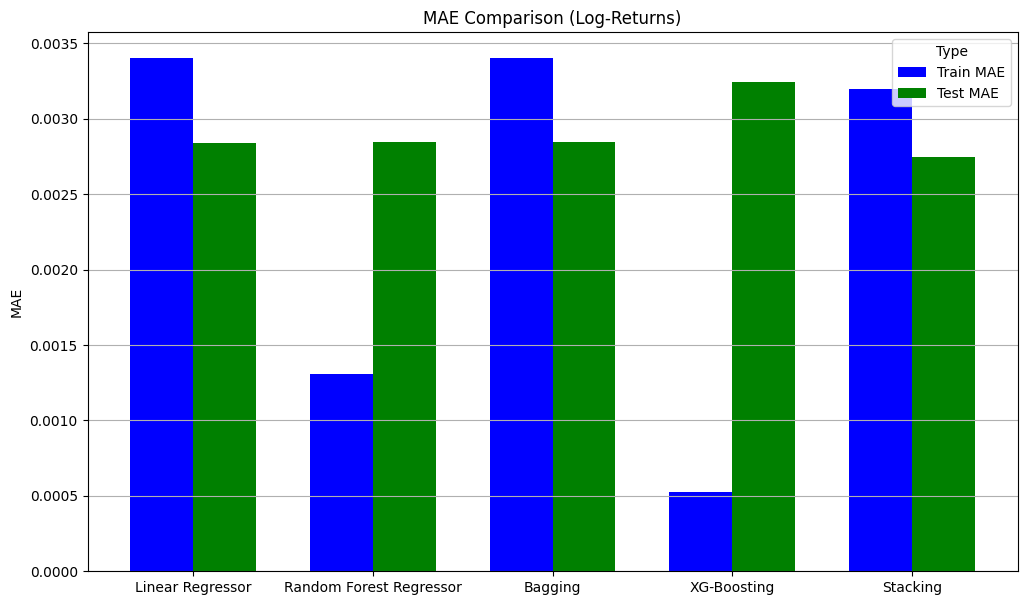

In [163]:
plt.figure(figsize=(12, 7))
x = ['Linear Regressor', 'Random Forest Regressor', 'Bagging', 'XG-Boosting', 'Stacking']
width = 0.35
plt.bar((np.arange(len(x))-width/2), [mae_train_linear_regression, mae_train_random_forest, mae_train_bagging, mae_train_xg_boost, mae_train_stacking], width, color='blue', label='Train MAE')
plt.bar((np.arange(len(x))+width/2), [mae_test_linear_regression, mae_test_random_forest, mae_test_bagging, mae_test_xg_boost, mae_test_stacking], width, color='green', label='Test MAE')
plt.title('MAE Comparison (Log-Returns)')
plt.xticks(np.arange(len(x)), x)
plt.ylabel('MAE')
plt.grid(axis='y')
plt.legend(title='Type')
plt.show()

#Find the Best Model

In [164]:
models = ['linear_regression_model', 'random_forest_model', 'bagging_model', 'xg_boost_model', 'stacking_model']
mae = [mae_test_linear_regression, mae_test_random_forest, mae_test_bagging, mae_test_xg_boost, mae_test_stacking]
best_mae = min(mae)
best_model_name = models[mae.index(best_mae)]
print("The best model is:", best_model_name)

The best model is: stacking_model


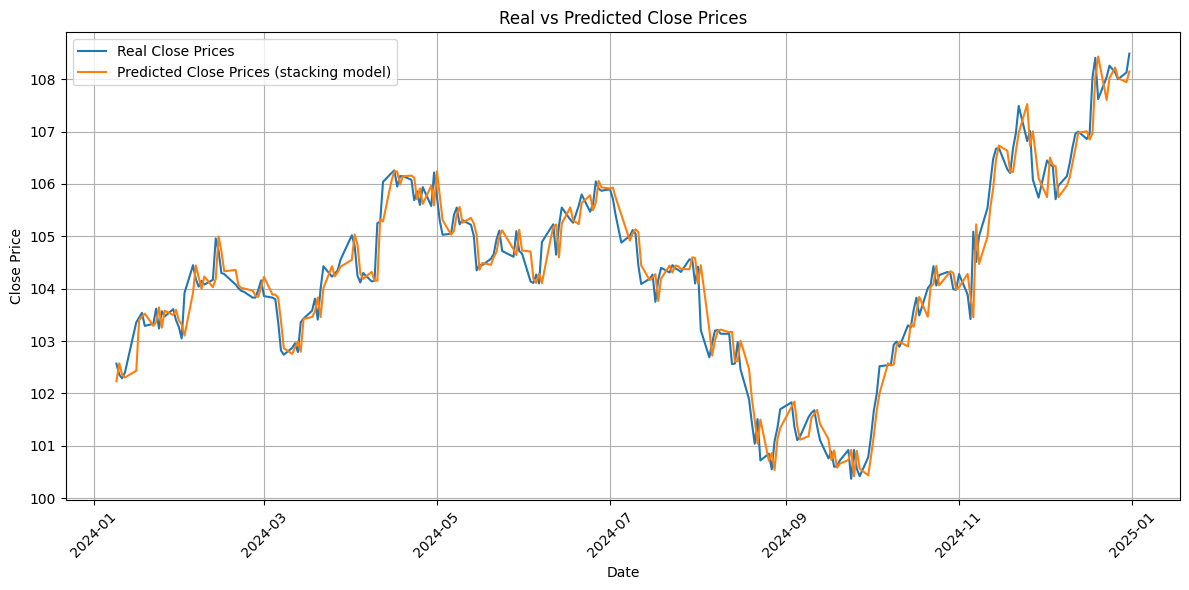

stacking_model — MAE in Close Prices (Test): 0.28648


In [175]:
models = {
    'linear_regression_model': linear_regression_model,
    'random_forest_model':     random_forest_model,
    'bagging_model':           bagging_model,
    'xg_boost_model':          xg_boost_model,
    'stacking_model':          stacking_model,
}
best_model = models[best_model_name]
y_pred_best = best_model.predict(x_test)
c_real = c_t_test * np.exp(np.asarray(y_test))
c_pred = c_t_test * np.exp(np.asarray(y_pred_best))

plt.figure(figsize=(12, 6))
plt.plot(y_dates_test, c_real, label='Real Close Prices')
plt.plot(y_dates_test, c_pred, label=f'Predicted Close Prices ({best_model_name.replace("_"," ")})')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Real vs Predicted Close Prices')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

mae_price_best = round(mean_absolute_error(c_real, c_pred), 6)
print(f"{best_model_name} — MAE in Close Prices (Test): {mae_price_best}")